In [1]:
!pip install tqdm  > debug.txt
!pip install tsfresh  > debug.txt

# Shot Classification on Arduino Nano 33 BLE Sense

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import tensorflow as tf

# Load the data from a CSV file
pull_shot_df = pd.read_csv('data/pull_shot_10min.csv', skiprows=[1])
square_cut_df= pd.read_csv('data/square_cut_10min.csv')
on_drive_df = pd.read_csv('data/on_drive_10min.csv', skiprows=[1])
cover_drive_df = pd.read_csv('data/cover_drive_10min.csv')


## Columns

In [4]:
def plot_data(data, shot_type):
    plt.figure(figsize=(15, 10))
    # Plot each sensor reading on the time axis with a unique color
    plt.plot(data['time'], data['gFx'], label='Gravity Force - X', color='red')
    plt.plot(data['time'], data['gFy'], label='Gravity Force - Y', color='green')
    plt.plot(data['time'], data['gFz'], label='Gravity Force - Z', color='blue')

    plt.plot(data['time'], data['ax'], label='Acceleration - X', color='orange')
    plt.plot(data['time'], data['ay'], label='Acceleration - Y', color='purple')
    plt.plot(data['time'], data['az'], label='Acceleration - Z', color='brown')

    plt.plot(data['time'], data['wx'], label='Angular Velocity - X', color='pink')
    plt.plot(data['time'], data['wy'], label='Angular Velocity - Y', color='grey')
    plt.plot(data['time'], data['wz'], label='Angular Velocity - Z', color='cyan')

    # Add legend
    plt.legend()

    # Title and Y-label
    plt.title('IMU Readings Over Time For '+ shot_type )
    plt.ylabel('Sensor Readings')
    # Hide x-axis labels
    plt.xticks([])

    # Display the plot
    plt.show()

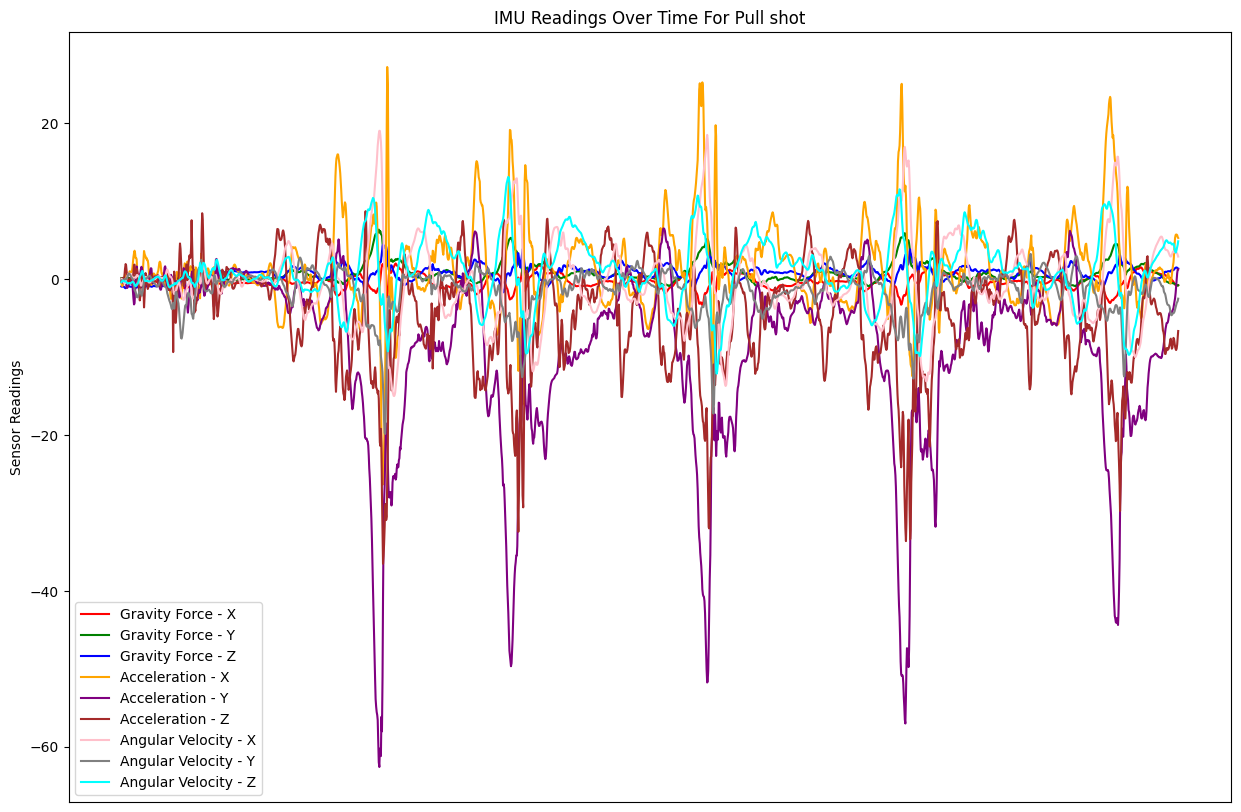

In [9]:
plot_data(pull_shot_df.head(2000), "Pull shot")

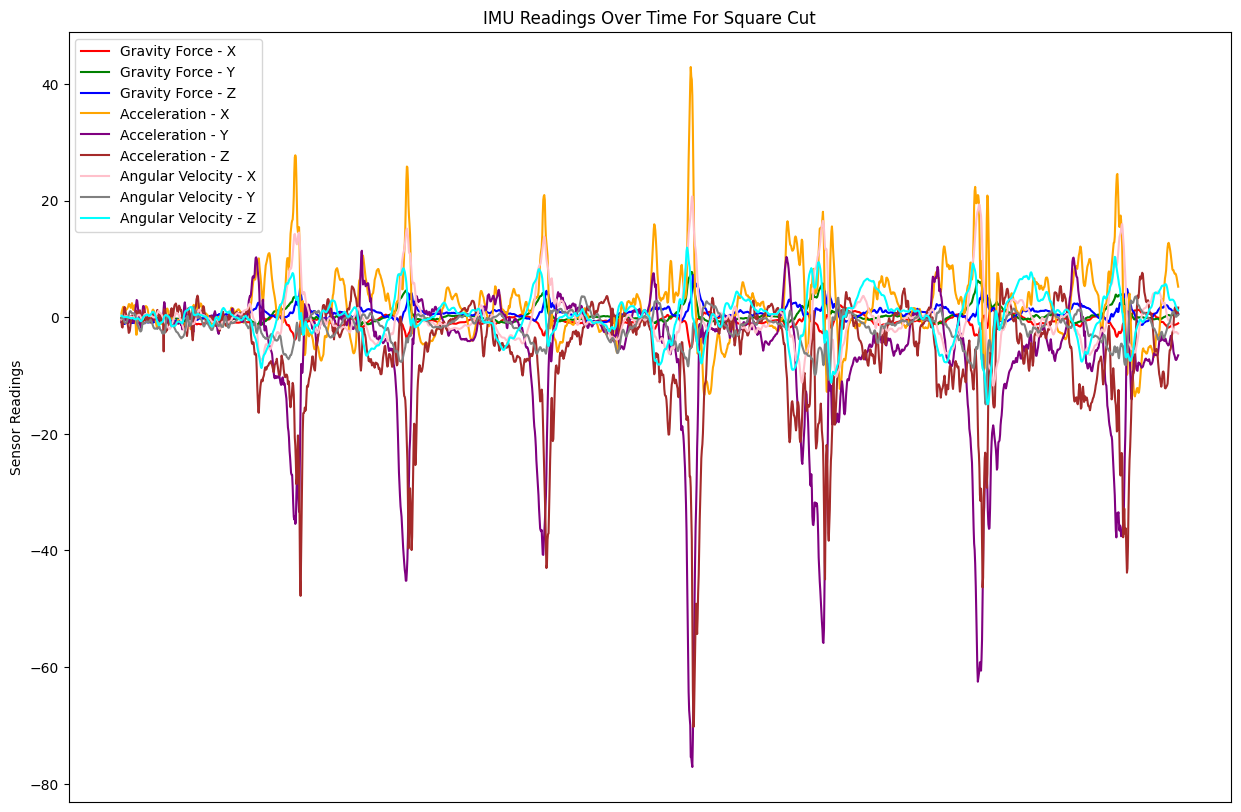

In [11]:
plot_data(square_cut_df.head(2000), "Square Cut")

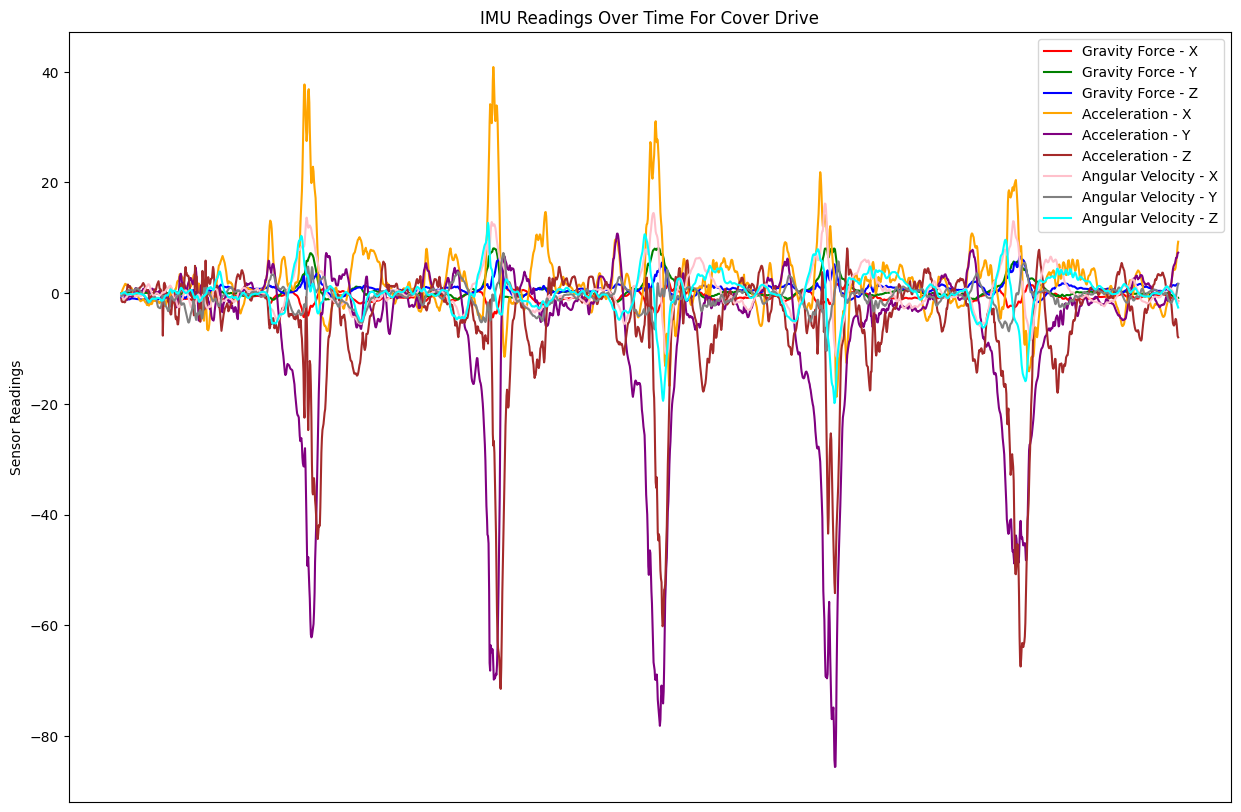

In [12]:
plot_data(cover_drive_df.head(2000), "Cover Drive")

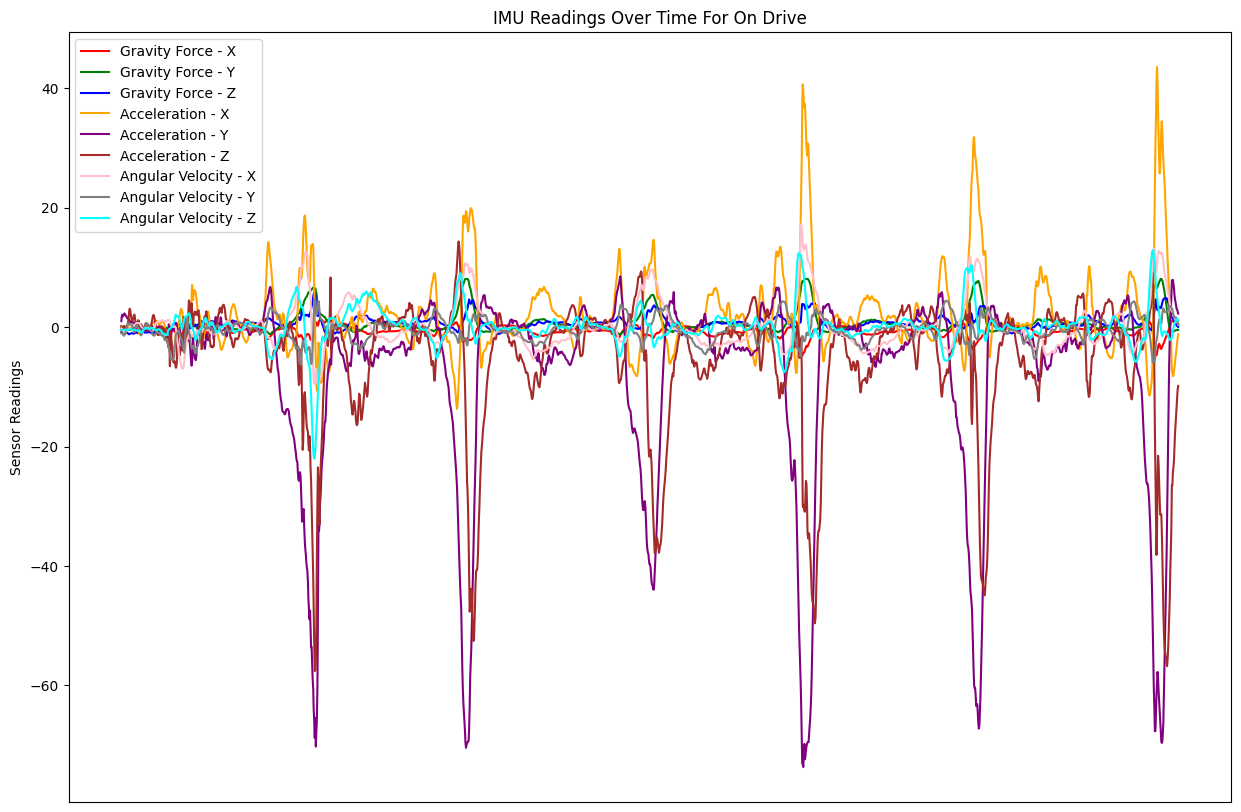

In [13]:
plot_data(on_drive_df.head(2000), "On Drive")

In [79]:
datasets = [pull_shot_df, square_cut_df, on_drive_df, cover_drive_df]
datasets_names = ["pull_shot_df", "square_cut_df", "on_drive_df", "cover_drive_df"]
datasets_dic = {
    "pull_shot_df":pull_shot_df,
    "square_cut_df":square_cut_df,
    "on_drive_df": on_drive_df,
    "cover_drive_df":cover_drive_df
}
for df in datasets:
    df['time'] = pd.to_datetime(df['time'])

# All columns in a dataframe to see
all_columns = list(pull_shot_df.columns)
signal_columns = all_columns.copy()
signal_columns.remove('time')
print("Columns: ", all_columns)
print("Signal columns", signal_columns)


# This shows that all shots have data of approximately just more than 10 minutes
for data in datasets:
    print(data.shape)


Columns:  ['time', 'gFx', 'gFy', 'gFz', 'ax', 'ay', 'az', 'wx', 'wy', 'wz']
Signal columns ['gFx', 'gFy', 'gFz', 'ax', 'ay', 'az', 'wx', 'wy', 'wz']
(61256, 10)
(61322, 10)
(61270, 10)
(61599, 10)


In [115]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from tqdm import tqdm
from scipy.signal import welch


# Function to calculate individual features for a Series
def mean(data):
    return np.mean(data)

def std(data):
    return np.std(data)

def min_value(data):
    return np.min(data)

def max_value(data):
    return np.max(data)

def num_peaks(data):
    return len(find_peaks(data)[0])


# Define a dictionary to map feature names to their corresponding functions
feature_functions = {
    'mean': mean,
    'std': std,
    'min': min_value,
    'max': max_value,
    'num_peaks': num_peaks
}

# Apply rolling window analysis
feature_datasets = {}
window_size = 281  # 1 second of data
step_size = 40     # 50% overlap

for df_name, df in datasets_dic.items():
    # Sort the DataFrame by time (if not already)
    df.sort_values('time', inplace=True)

    # Extract features for each column and store in a list
    # Extract features for each column and store in a list
    features_list = []
    for column in tqdm(signal_columns, desc=f"Extracting features for {df_name}"):
        # Initialize a DataFrame to store features for this column
        column_features = pd.DataFrame({
            'time': df['time'][window_size-1::step_size].values  # Adjust the time index to match the window
        })

        # Calculate each feature and add to the DataFrame
        for feature_name, func in feature_functions.items():
            result = df[column].rolling(window=window_size, min_periods=window_size).apply(func, raw=True)
            # Append the signal name to each feature name
            column_features[f'{column}_{feature_name}'] = result[window_size-1::step_size].values  # Adjust the index to match the window

        # Calculate spectral features for each window and add to the DataFrame
        spectral_features_list = []
        for start in range(0, len(df[column]), step_size):
            end = start + window_size
            if end <= len(df[column]):
                spectral_result = spectral_features(df[column][start:end], 100)
                for feature_name, value in spectral_result.items():
                    column_features[f'{column}_{feature_name}'] = value
                spectral_features_list.append(pd.Series(spectral_result))

        features_list.append(column_features.set_index('time'))

    # Combine all features for this dataset
    feature_datasets[df_name] = pd.concat(features_list, axis=1)

# Example output
print(feature_datasets['pull_shot_df'].head())


Extracting features for cover_drive_df: 100%|██████████| 9/9 [00:47<00:00,  5.29s/it]

                         gFx_mean   gFx_std  gFx_min  gFx_max  gFx_num_peaks  \
time                                                                           
2024-04-10 14:38:41.304 -0.529349  0.256279   -1.202    0.099           39.0   
2024-04-10 14:38:41.701 -0.556587  0.234576   -1.202   -0.015           35.0   
2024-04-10 14:38:42.099 -0.568786  0.226625   -1.202   -0.015           34.0   
2024-04-10 14:38:42.496 -0.514601  0.235649   -1.202   -0.015           34.0   
2024-04-10 14:38:42.894 -0.549032  0.431271   -2.151    0.387           27.0   

                         gFx_max_power_freq  gFx_total_power  gFx_avg_power  \
time                                                                          
2024-04-10 14:38:41.304            0.390625         0.220223       0.001707   
2024-04-10 14:38:41.701            0.390625         0.220223       0.001707   
2024-04-10 14:38:42.099            0.390625         0.220223       0.001707   
2024-04-10 14:38:42.496            0.390625 

In [116]:
feature_datasets['pull_shot_df'].head(5)

,gFx_mean,gFx_std,gFx_min,gFx_max,gFx_num_peaks,gFx_max_power_freq,gFx_total_power,gFx_avg_power,gFy_mean,gFy_std,...,wy_total_power,wy_avg_power,wz_mean,wz_std,wz_min,wz_max,wz_num_peaks,wz_max_power_freq,wz_total_power,wz_avg_power
time,,,,,,,,,,,,,,,,,,,,,
2024-04-10 14:38:41.304,-0.529349,0.256279,-1.202,0.099,39.0,0.390625,0.220223,0.001707,0.034256,0.118530,...,2.512331,0.019475,0.167722,0.690279,-1.10,2.45,19.0,0.390625,2.528839,0.019603
2024-04-10 14:38:41.701,-0.556587,0.234576,-1.202,-0.015,35.0,0.390625,0.220223,0.001707,0.067274,0.201796,...,2.512331,0.019475,0.338612,0.857889,-1.10,2.83,16.0,0.390625,2.528839,0.019603
2024-04-10 14:38:42.099,-0.568786,0.226625,-1.202,-0.015,34.0,0.390625,0.220223,0.001707,0.175665,0.344289,...,2.512331,0.019475,0.239075,0.983482,-1.71,2.83,17.0,0.390625,2.528839,0.019603
2024-04-10 14:38:42.496,-0.514601,0.235649,-1.202,-0.015,34.0,0.390625,0.220223,0.001707,0.183381,0.345691,...,2.512331,0.019475,0.299288,1.102608,-1.71,2.83,14.0,0.390625,2.528839,0.019603
2024-04-10 14:38:42.894,-0.549032,0.431271,-2.151,0.387,27.0,0.390625,0.220223,0.001707,0.157719,0.387541,...,2.512331,0.019475,-0.333843,2.056459,-6.77,2.83,14.0,0.390625,2.528839,0.019603


In [117]:
concatenated_df = pd.concat([df.assign(label=df_name) for df_name, df in feature_datasets.items()])
shuffled_df = concatenated_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [118]:
shuffled_df.head()

,gFx_mean,gFx_std,gFx_min,gFx_max,gFx_num_peaks,gFx_max_power_freq,gFx_total_power,gFx_avg_power,gFy_mean,gFy_std,...,wy_avg_power,wz_mean,wz_std,wz_min,wz_max,wz_num_peaks,wz_max_power_freq,wz_total_power,wz_avg_power,label
0,-0.432107,0.300672,-1.264,0.861,21.0,0.390625,0.220223,0.001707,0.065986,0.437854,...,0.019475,-0.129644,1.608933,-5.32,4.51,13.0,0.390625,2.528839,0.019603,pull_shot_df
1,-0.504651,0.630893,-3.205,0.477,21.0,0.390625,0.214411,0.001662,0.126431,1.271245,...,0.047498,-0.156762,2.582932,-5.75,8.34,14.0,1.953125,1.990662,0.015431,square_cut_df
2,-0.533790,0.892439,-2.959,0.865,17.0,0.390625,0.616464,0.004779,0.652836,1.829343,...,0.152491,0.604626,3.250327,-5.21,14.00,14.0,1.171875,11.447940,0.088744,cover_drive_df
3,-0.632925,0.663793,-2.185,0.598,19.0,0.390625,2.801710,0.021719,0.819979,1.225509,...,0.029642,0.057331,2.147657,-4.67,7.08,14.0,0.390625,6.365851,0.049348,on_drive_df
4,-0.705096,0.604979,-2.786,0.395,15.0,0.390625,0.214411,0.001662,0.282014,0.930096,...,0.047498,-0.086085,2.908179,-7.08,6.92,13.0,1.953125,1.990662,0.015431,square_cut_df


In [120]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Split the dataset into features (X) and labels (y)
X = shuffled_df.drop(columns=['label'])
y = shuffled_df['label']

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to numerical values using LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define a neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Softmax layer for multi-class classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the testing set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict on the testing set
y_pred_probs = model.predict(X_test)
y_pred = label_encoder.inverse_transform(tf.argmax(y_pred_probs, axis=1))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Epoch 1/20
123/123 [==============================] - 2s 6ms/step - loss: 5.1069 - accuracy: 0.6721 - val_loss: 0.0332 - val_accuracy: 1.0000
Epoch 2/20
123/123 [==============================] - 0s 3ms/step - loss: 0.4387 - accuracy: 0.8862 - val_loss: 0.0165 - val_accuracy: 0.9990
Epoch 3/20
123/123 [==============================] - 0s 3ms/step - loss: 0.1780 - accuracy: 0.9404 - val_loss: 0.0087 - val_accuracy: 1.0000
Epoch 4/20
123/123 [==============================] - 0s 3ms/step - loss: 0.1069 - accuracy: 0.9670 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 5/20
123/123 [==============================] - 0s 3ms/step - loss: 0.0778 - accuracy: 0.9760 - val_loss: 5.5851e-04 - val_accuracy: 1.0000
Epoch 6/20
123/123 [==============================] - 0s 3ms/step - loss: 0.0547 - accuracy: 0.9821 - val_loss: 5.6252e-04 - val_accuracy: 1.0000
Epoch 7/20
123/123 [==============================] - 0s 3ms/step - loss: 0.0450 - accuracy: 0.9841 - val_loss: 1.9363e-04 - val_accuracy: 1

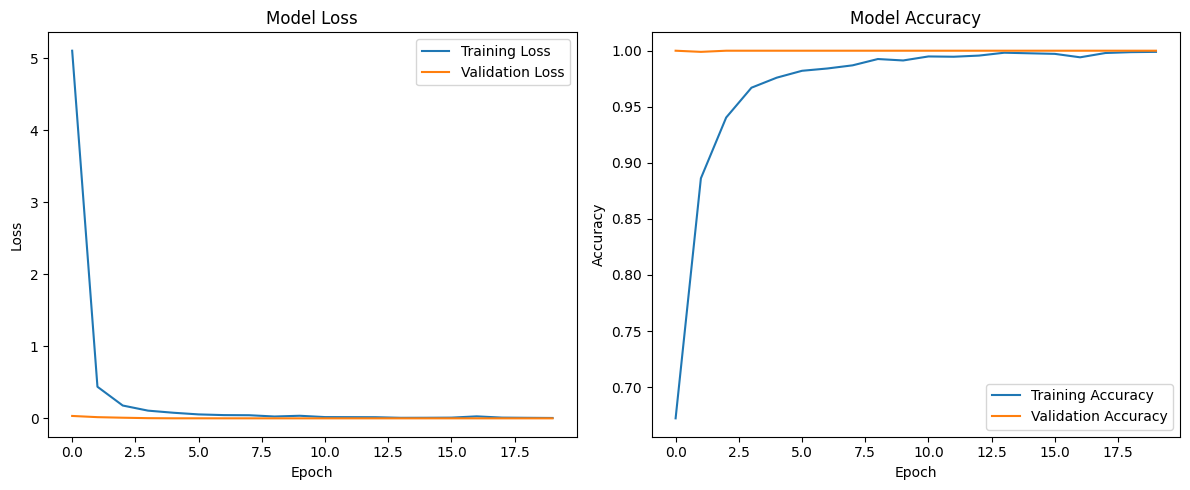

In [121]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 5))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Baseline Accuracy: 1.0


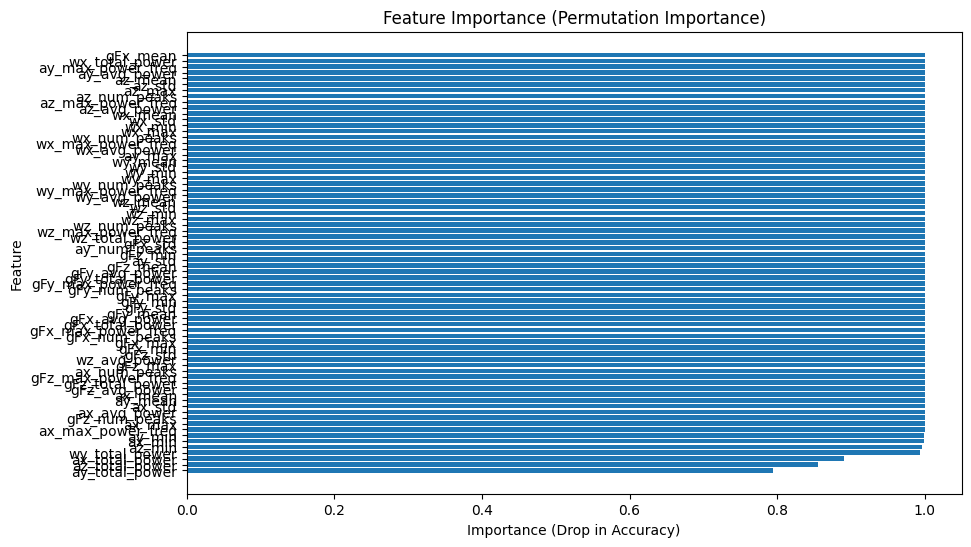

In [124]:
# Calculate baseline accuracy on the testing set
baseline_loss, baseline_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print("Baseline Accuracy:", baseline_accuracy)

# Calculate feature importance using permutation importance
permuted_accuracies = []
for feature in X_test.columns:
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test[feature])
    loss, accuracy = model.evaluate(X_test_permuted, y_test_encoded, verbose=0)
    permuted_accuracies.append(accuracy)

# Create a DataFrame to store feature names and importances
feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': permuted_accuracies  # Use permuted_accuracies instead of feature_importance
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5])
plt.xlabel('Importance (Drop in Accuracy)')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()


In [126]:

X.columns

Index(['gFx_mean', 'gFx_std', 'gFx_min', 'gFx_max', 'gFx_num_peaks',
       'gFx_max_power_freq', 'gFx_total_power', 'gFx_avg_power', 'gFy_mean',
       'gFy_std', 'gFy_min', 'gFy_max', 'gFy_num_peaks', 'gFy_max_power_freq',
       'gFy_total_power', 'gFy_avg_power', 'gFz_mean', 'gFz_std', 'gFz_min',
       'gFz_max', 'gFz_num_peaks', 'gFz_max_power_freq', 'gFz_total_power',
       'gFz_avg_power', 'ax_mean', 'ax_std', 'ax_min', 'ax_max',
       'ax_num_peaks', 'ax_max_power_freq', 'ax_total_power', 'ax_avg_power',
       'ay_mean', 'ay_std', 'ay_min', 'ay_max', 'ay_num_peaks',
       'ay_max_power_freq', 'ay_total_power', 'ay_avg_power', 'az_mean',
       'az_std', 'az_min', 'az_max', 'az_num_peaks', 'az_max_power_freq',
       'az_total_power', 'az_avg_power', 'wx_mean', 'wx_std', 'wx_min',
       'wx_max', 'wx_num_peaks', 'wx_max_power_freq', 'wx_total_power',
       'wx_avg_power', 'wy_mean', 'wy_std', 'wy_min', 'wy_max', 'wy_num_peaks',
       'wy_max_power_freq', 'wy_total_power'

## Visualization

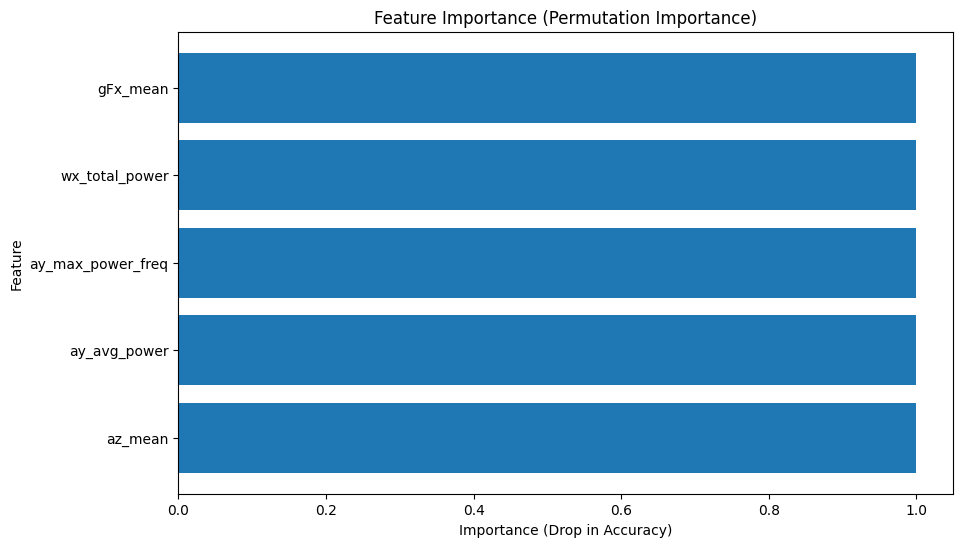

In [125]:

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:5], feature_importance_df['Importance'][:5])
plt.xlabel('Importance (Drop in Accuracy)')
plt.ylabel('Feature')
plt.title('Feature Importance (Permutation Importance)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.show()

## Preparing Windows

In each of the graphs above, there are spikes. While these spikes are unique to each shot played. The distance between each spike denotes a shot. THerefore, to prepare individual shot samples, we need to measure the frequency of each shot that is played.

In [ ]:
import numpy as np
from scipy.signal import find_peaks
from scipy.signal import welch

def estimate_average_frequency(df, signal_column_name):
    """
    Estimate the average frequency of a waveform using Welch's method.

    :param df: pandas DataFrame containing the time and signal columns.
    :param signal_column_name: The name of the column containing the signal data.
    :param time_column_name: The name of the column containing the time data.
    :return: The estimated average frequency.
    """
    time_column_name = "time"
    # Ensure time is sorted, just in case
    df = df.sort_values(by=time_column_name)

    # Calculate sampling intervals
    time_diffs = df[time_column_name].diff().dt.total_seconds().dropna()
    average_sampling_interval = time_diffs.mean()

    # Calculate sampling frequency
    fs = 1.0 / average_sampling_interval

    # Extract the signal
    signal = df[signal_column_name].values

    # Use Welch's method to estimate the power spectral density of the signal
    freqs, psd = welch(signal, fs)

    # Find the peak frequency in the power spectral density
    peak_freq = freqs[np.argmax(psd)]

    return peak_freq


for i, df in enumerate(datasets):
    peak_freq = estimate_average_frequency(df, 'ay')  # You may need to adjust the threshold
    print(f'{datasets_names[i]} -- Peak Freq: {peak_freq}')


 Choosing a the window size as  2.5s = (1/0.39). But let's take it to 2.8
 Sliding window shift. Let's use the sliding window shift as 0.4s

## Preparing training and testing dataset

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [62]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with dates and values
np.random.seed(0)
dates = pd.date_range(start='2023-01-01', periods=100, freq='D')
values = np.random.randn(100)  # Random values

df = pd.DataFrame(data=values, index=dates, columns=['Value'])

# Define the window size
window_size = 5

# Create rolling window samples
rolling_windows = df['Value'].rolling(window=window_size)

# Example to calculate the mean for each window
mean_per_window = rolling_windows.mean()

# Example to extract windowed data into a list of arrays (if needed)
windowed_data = [df.iloc[window].values.flatten() for window in rolling_windows.indices.values() if len(df.iloc[window]) == window_size]

print("Mean per window:")
print(mean_per_window.dropna())  # Drop NA values that appear for the first few windows less than window_size

# To see some of the windowed data samples
print("\nSample windowed data:")
for i, window in enumerate(windowed_data[:3]):  # Show first 3 full windows
    print(f"Window {i + 1}: {window}")


AttributeError: 'Rolling' object has no attribute 'indices'

In [51]:
all_datasets = pd.concat([pull_shot_dataset, square_cut_dataset, on_drive_dataset, cover_drive_dataset])

# Shuffle the combined dataset
shuffled_dataset = all_datasets.sample(frac=1, random_state=42).reset_index(drop=True)


In [52]:
shuffled_dataset

,Window,Label
0,gFx gFy gFz ax ay az ...,pull_shot
1,gFx gFy gFz ax ay az ...,square_cut
2,gFx gFy gFz ax ay az ...,cover_drive
3,gFx gFy gFz ax ay az ...,on_drive
4,gFx gFy gFz ax ay az ...,square_cut
...,...,...
6105,gFx gFy gFz ax ay az ...,on_drive
6106,gFx gFy gFz ax ay az ...,cover_drive
6107,gFx gFy gFz ax ay az...,cover_drive
6108,gFx gFy gFz ax ay az ...,cover_drive


In [61]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters

# Assume you have a function to flatten your windows if necessary
def flatten_windows(batch_df):
    # Flatten or prepare each window
    # Dummy function: replace it with actual logic to flatten each window as needed
    return batch_df

# Decide on a batch size
batch_size = 10  # Adjust this based on memory constraints

# Initialize an empty list to collect DataFrames for features
features_list = []

# Process the dataset in batches
for start in range(0, len(shuffled_dataset), batch_size):
    end = min(start + batch_size, len(shuffled_dataset))
    batch_df = shuffled_dataset.iloc[start:end]

    # Flatten the windows if necessary
    flattened_batch_df = flatten_windows(batch_df)

    # Convert each sensor's readings into a long format
    batch_long_df = pd.melt(flattened_batch_df, id_vars=['Label'], var_name='variable', value_name='value')
    batch_long_df['id'] = range(start, end)

    # Extract features using the long format DataFrame
    extracted_features = extract_features(batch_long_df,
                                          column_id='id',
                                          column_value='value',
                                          default_fc_parameters=EfficientFCParameters(),
                                          impute_function=impute)

    # Attach labels
    labels = batch_df['Label'].tolist()
    extracted_features['Label'] = labels

    # Append the features DataFrame to the list
    features_list.append(extracted_features)

# Concatenate all feature DataFrames into one DataFrame
features_df = pd.concat(features_list, ignore_index=True)


Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]


TypeError: loop of ufunc does not support argument 0 of type DataFrame which has no callable conjugate method

In [17]:
def concatenate_and_split_datasets(datasets, train_split=0.7, val_split=0.15, test_split=0.15, shuffle_buffer_size=10000):
    # Concatenate datasets
    combined_dataset = datasets[0]
    for dataset in datasets[1:]:
        combined_dataset = combined_dataset.concatenate(dataset)

    # Shuffle the combined dataset
    combined_dataset = combined_dataset.shuffle(buffer_size=shuffle_buffer_size)

    # Calculate dataset size
    dataset_size = combined_dataset.cardinality().numpy()

    # Calculate sizes for train, validation, and test sets
    train_size = int(train_split * dataset_size)
    val_size = int(val_split * dataset_size)

    # Split the dataset
    train_dataset = combined_dataset.take(train_size)
    val_dataset = combined_dataset.skip(train_size).take(val_size)
    test_dataset = combined_dataset.skip(train_size + val_size)

    return train_dataset, val_dataset, test_dataset

# Assuming your datasets are named accordingly and already created
all_datasets = [pull_shot_dataset, square_cut_dataset, on_drive_dataset, cover_drive_dataset]

# Split the data
train_dataset, val_dataset, test_dataset = concatenate_and_split_datasets(all_datasets, train_split=0.7, val_split=0.15, test_split=0.15, shuffle_buffer_size=10000)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# Define the model
model = Sequential([
    # SimpleRNN layer
    # Assuming each window has shape (timesteps, features)
    # 'input_shape' should be the shape of a single sample, excluding the batch size
    SimpleRNN(64, input_shape=(281,9), activation='relu'),
    # Output layer
    # Assuming your task is a classification with 'n_classes' being the number of classes
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 64)                4736      
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 4996 (19.52 KB)
Trainable params: 4996 (19.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=10)


Epoch 1/10


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 281, 9), found shape=(281, 9)


39/39 [==============================] - 0s 3ms/step - loss: 5.3909e-06 - accuracy: 1.0000


[5.390891601564363e-06, 1.0]